In [1]:
import argparse
import torch
import torch.nn as nn
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import numpy as np
import time

In [2]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [3]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

_StoreAction(option_strings=['--extra_tag'], dest='extra_tag', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='Anything extra', metavar=None)

In [4]:
# argument_text로 parser의 argument 지정 - 반드시 불러오는 모델과 동일하게 지정해야 함.

parse_seq = """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/weather/ \
  --data_path weather.csv \
  --model_id weather_24_24_t \
  --model iTransformer \
  --data custom \
  --features M \
  --seq_len 24 \
  --label_len 12 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 21 \
  --dec_in 21 \
  --c_out 21 \
  --des 'Exp' \
  --d_model 64\
  --d_ff 64\
  --itr 1
"""
args = parser.parse_args(parse_seq.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, batch_size=32, c_out=21, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=64, d_layers=1, d_model=64, data='custom', data_path='weather.csv', dec_in=21, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=21, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=12, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='weather_24_24_t', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_hidden_dims=[128, 128], p_hidden_layers=2, 

In [5]:
# 모델 호출 - Exp_Long_Term_Forecast
exp_model = Exp_Long_Term_Forecast(args)

Use GPU: cuda:0


In [6]:
# arguments 바탕으로 모델 생성
exp_model._build_model()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=24, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

In [7]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
setting_path = 'long_term_forecast_weather_24_24_t_iTransformer_custom_ftM_sl24_ll12_pl24_dm64_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0(1724912314)'
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [8]:
# weather 데이터 불러오기 -> 96단위로 절단하기

from data_provider.data_loader import Dataset_Custom

args.seq_len=96 # 입력길이 재조정
args.pred_len=96 # 출력길이 재조정

dataset_weather_96 = Dataset_Custom(args, './dataset/weather/',
                                    flag='train', size=(96, 48, 96),
                                    features='M', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [9]:
# 데이터 결과물 추출
dataset_weather_96[1][0].shape

(96, 21)

In [10]:
# train_set 데이터
# 24단위로 분할, 24 출력
dataset_weather_24 = Dataset_Custom(args, './dataset/weather/',
                                    flag='train', size=(24, 12, 24),
                                    features='M', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [11]:
# validation set 데이터
# 24단위로 분할, 24 출력
dataset_weather_24_val = Dataset_Custom(args, './dataset/weather/',
                                    flag='val', size=(24, 12, 24),
                                    features='M', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [12]:
# 테스트 셋 데이터
# 24단위로 분할, 24 출력
dataset_weather_24_test = Dataset_Custom(args, './dataset/weather/',
                                    flag='test', size=(24, 12, 24),
                                    features='M', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [13]:
dataset_weather_24[1] # seq_x, seq_y, seq_mark_x, seq_mark_y

(array([[ 2.09919445, -1.45479774, -1.60288224, -1.0696124 ,  0.94214123,
         -1.13871421, -0.99050594, -0.82833236, -1.00922797, -1.00807164,
          1.93278769, -0.02912541, -1.1251405 ,  0.35433863, -0.09350552,
         -0.22105042, -0.67276674, -0.67949278, -0.58829564, -1.41661176,
          0.04413425],
        [ 2.08760791, -1.45738895, -1.60414539, -1.07580013,  0.93680937,
         -1.13994739, -0.99278064, -0.82663822, -1.00922797, -1.012554  ,
          1.93173694, -0.02567048, -0.87860612,  0.24279826, -0.09350552,
         -0.22105042, -0.67276674, -0.67949278, -0.58829564, -1.40533073,
          0.04309247],
        [ 2.08529061, -1.5040306 , -1.64835586, -1.10055106,  1.00079176,
         -1.16091154, -1.00870354, -0.84357957, -1.02351429, -1.02600108,
          1.97586831, -0.01607344, -0.87860612,  0.34973903, -0.09350552,
         -0.22105042, -0.67276674, -0.67949278, -0.58829564, -1.39279625,
          0.04934316],
        [ 2.08181465, -1.50921301, -1.65340

In [14]:
# 모델 훈련셋 결과 확인하기
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader

args.seq_len=24 # 입력길이 재조정
args.pred_len=24 # 출력길이 재조정
# dataset_weather_24에서 loader 생성
dataset_weather_24_loader = DataLoader(
            dataset_weather_24,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=True,
            num_workers=args.num_workers,
            drop_last=False)

In [15]:
# 측정 모드로 전환
exp_model.model.eval()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=24, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

In [16]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = []
trues_te_tr = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)

In [17]:
len(dataset_weather_24), len(dataset_weather_24_loader), len(preds_te_tr)

(36840, 36840, 36840)

In [18]:
# metric 호출
from utils.metrics import *

In [20]:
# 전체 MAE, MSE, REC_CORR, SMAE
"MAE", MAE(preds_te_tr, trues_te_tr),"MSE", MSE(preds_te_tr, trues_te_tr),"ME", SMAE(preds_te_tr, trues_te_tr),"REC_CORR", REC_CORR(preds_te_tr, trues_te_tr),

('MAE',
 0.27212238,
 'MSE',
 0.4416116,
 'ME',
 0.010631034,
 'REC_CORR',
 0.017945072755957792)

In [21]:
# 변수별 TE 분포
for j in range(21):
    # 전체 MAE, MSE, REC_CORR, SMAE
    print(f"Variable {j}")
    print("MAE", MAE(preds_te_tr[:,:,j], trues_te_tr[:,:,j]),"MSE", MSE(preds_te_tr[:,:,j], trues_te_tr[:,:,j]),"ME", SMAE(preds_te_tr[:,:,j], trues_te_tr[:,:,j]),"REC_CORR", REC_CORR(preds_te_tr[:,:,j], trues_te_tr[:,:,j]),)

Variable 0
MAE 0.09769549 MSE 0.020585058 ME 0.004206254 REC_CORR -0.027628637952270347
Variable 1
MAE 0.2422755 MSE 0.11484807 ME -0.002811124 REC_CORR 0.038290503207836016
Variable 2
MAE 0.23989442 MSE 0.112008624 ME -0.0026094979 REC_CORR 0.03820329467529263
Variable 3
MAE 0.13287897 MSE 0.037698302 ME 0.0051403344 REC_CORR -0.0006147970071626569
Variable 4
MAE 0.4462951 MSE 0.38577452 ME 0.036487006 REC_CORR -0.015380912510803918
Variable 5
MAE 0.2476515 MSE 0.14680587 ME -0.0027955566 REC_CORR 0.04173022303772608
Variable 6
MAE 0.13186407 MSE 0.041236557 ME 0.005618742 REC_CORR 0.00044470177146855455
Variable 7
MAE 0.35559213 MSE 0.3260421 ME -0.0033192914 REC_CORR 0.0383272484971162
Variable 8
MAE 0.13140143 MSE 0.041037336 ME 0.0055939136 REC_CORR 0.0001950660238722563
Variable 9
MAE 0.13140391 MSE 0.040963206 ME 0.005587588 REC_CORR 0.00023880720529273434
Variable 10
MAE 0.2290118 MSE 0.099140115 ME 0.018181654 REC_CORR -0.02802102005104107
Variable 11
MAE 0.030517304 MSE 1.177

In [22]:
# test 데이터셋 기준으로 loader

dataset_weather_24_test_loader = DataLoader(
            dataset_weather_24_test,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [23]:
# 테스트 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_te = []
trues_te_te = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_test_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_te.append(pred)
    trues_te_te.append(true)

preds_te_te = np.concatenate(preds_te_te, axis=0)
trues_te_te = np.concatenate(trues_te_te, axis=0)

In [24]:
# 전체 MAE, MSE, REC_CORR, SMAE
"MAE", MAE(preds_te_te, trues_te_te),"MSE", MSE(preds_te_te, trues_te_te),"ME", SMAE(preds_te_te, trues_te_te),"REC_CORR", REC_CORR(preds_te_te, trues_te_te),

('MAE',
 0.15319279,
 'MSE',
 0.12791905,
 'ME',
 0.0056374236,
 'REC_CORR',
 0.02457467775227358)

In [25]:
# 변수별 TE 분포
for j in range(21):
    # 전체 MAE, MSE, REC_CORR, SMAE
    print(f"Variable {j}")
    print("MAE", MAE(preds_te_te[:,:,j], trues_te_te[:,:,j]),"MSE", MSE(preds_te_te[:,:,j], trues_te_te[:,:,j]),"ME", SMAE(preds_te_te[:,:,j], trues_te_te[:,:,j]),"REC_CORR", REC_CORR(preds_te_te[:,:,j], trues_te_te[:,:,j]),)

Variable 0
MAE 0.09816509 MSE 0.019342855 ME 0.0005178148 REC_CORR -0.01613609731830492
Variable 1
MAE 0.14632021 MSE 0.049184844 ME -0.00035747074 REC_CORR 0.032786904643343454
Variable 2
MAE 0.14499322 MSE 0.04808555 ME 9.121403e-05 REC_CORR 0.029952624491509528
Variable 3
MAE 0.10819935 MSE 0.023998259 ME -0.00016292541 REC_CORR 0.02421679821608252
Variable 4
MAE 0.27646562 MSE 0.17095259 ME 0.016384972 REC_CORR -0.0031914376594517637
Variable 5
MAE 0.0962077 MSE 0.0230895 ME -2.5285308e-05 REC_CORR 0.0345322217509791
Variable 6
MAE 0.09005467 MSE 0.017010707 ME 0.00010340554 REC_CORR 0.02513721943130325
Variable 7
MAE 0.10813963 MSE 0.032294996 ME 0.0017565116 REC_CORR 0.03226649038455789
Variable 8
MAE 0.08946037 MSE 0.016815677 ME 0.00015988706 REC_CORR 0.025360221555503958
Variable 9
MAE 0.08962465 MSE 0.016868547 ME 0.00014881157 REC_CORR 0.025169636091292993
Variable 10
MAE 0.15159263 MSE 0.05048114 ME 0.010326216 REC_CORR -0.013557442674615613
Variable 11
MAE 0.014696949 MSE 

In [26]:
# last_var
metric_path = f"./results/{setting_path}/metrics.npy"
metric_obj = np.load(metric_path)

In [27]:
metric_obj # np.array([mae, mse, rmse, mape, mspe, smae, mae_ratio, corr])

array([1.37906685e-01, 1.18114106e-01, 3.43677342e-01, 1.19533958e+01,
       3.01922620e+07, 8.15245416e-03, 1.30184466e-01, 3.69352839e-02])

In [28]:
"MAE", metric_obj[0], "MSE", metric_obj[1], "ME", metric_obj[5], "REC_CORR", metric_obj[7]

('MAE',
 0.13790668547153473,
 'MSE',
 0.11811410635709763,
 'ME',
 0.008152454160153866,
 'REC_CORR',
 0.036935283862475445)

In [29]:
preds_te_tr.shape, len(dataset_weather_24_loader)

((36840, 24, 21), 36840)

In [30]:
# 차이 있는지 확인
pred_obj_path = f"./results/{setting_path}/pred.npy"
pred_obj = np.load(pred_obj_path) # 테스트값은 다소 차이가 있을수 있음 preds_te_te와 다름.
true_obj_path = f"./results/{setting_path}/true.npy"
true_obj = np.load(true_obj_path) # 찹값은 동일 즉 trues_te_te와 동일

In [31]:

MSE(pred_obj, preds_te_te), MAE(pred_obj, preds_te_te), np.sum(true_obj==trues_te_te)/trues_te_te.size

(0.012456699, 0.04027696, 1.0)

In [21]:
# 이번엔 pred_te_tr 데이터를 이용해서 예측하는 방법
# 입력데이터 batch_x 대신 pred_te_tr 데이터로 치환하기. dataset_weather_24_loader 데이터는 그대로 

# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_tr_tr = []
trues_tr_tr = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):
    if i>=24:
        batch_x_1 = torch.Tensor(preds_te_tr[i-24:i-23,:,:]).to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs = exp_model.model(batch_x_1, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
    
        pred = outputs
        true = batch_y
    
        preds_tr_tr.append(pred)
        trues_tr_tr.append(true)


preds_tr_tr = np.concatenate(preds_tr_tr, axis=0)
trues_tr_tr = np.concatenate(trues_tr_tr, axis=0)

In [23]:
preds_tr_tr.shape, trues_tr_tr.shape

((36816, 24, 21), (36816, 24, 21))

In [104]:
# 예측값->예측값이랑 참값 차이 검증
# 전체 MAE, MSE, REC_CORR, SMAE
"MAE", MAE(preds_tr_tr, trues_tr_tr),"MSE", MSE(preds_tr_tr, trues_tr_tr),"ME", SMAE(preds_tr_tr, trues_tr_tr),"REC_CORR", REC_CORR(preds_tr_tr, trues_tr_tr),

('MAE',
 0.90208614,
 'MSE',
 1.8425195,
 'ME',
 -0.005557746,
 'REC_CORR',
 0.005772403139146247)

In [105]:
# 예측값->예측값이랑 참값-> 예측값 차이 검증
# 전체 MAE, MSE, REC_CORR, SMAE
"MAE", MAE(preds_tr_tr, preds_te_tr[24:]),"MSE", MSE(preds_tr_tr, preds_te_tr[24:]),"ME", SMAE(preds_tr_tr, preds_te_tr[24:]),"REC_CORR", REC_CORR(preds_tr_tr, preds_te_tr[24:]),

('MAE',
 0.89288324,
 'MSE',
 1.6996361,
 'ME',
 -0.01625349,
 'REC_CORR',
 0.3837091354610462)

In [115]:
# 변수별 TE 분포
for j in range(21):
    # 전체 MAE, MSE, REC_CORR, SMAE
    print(f"Variable {j}")
    print("MAE", MAE(preds_tr_tr[:,:,j], trues_tr_tr[:,:,j]),"MSE", MSE(preds_tr_tr[:,:,j], trues_tr_tr[:,:,j]),"ME", SMAE(preds_tr_tr[:,:,j], trues_tr_tr[:,:,j]),"REC_CORR", REC_CORR(preds_tr_tr[:,:,j], trues_tr_tr[:,:,j]),)

Variable 0
MAE 1.1048406 MSE 1.9954665 ME -0.0006760667 REC_CORR -0.0007761323088674348
Variable 1
MAE 1.1385347 MSE 1.9809713 ME -0.01521777 REC_CORR 0.001066430171834305
Variable 2
MAE 1.1384584 MSE 1.9802475 ME -0.014915515 REC_CORR 0.0013922876377512206
Variable 3
MAE 1.138213 MSE 1.9817437 ME -0.0017148514 REC_CORR 0.0011485206082351516
Variable 4
MAE 1.1385341 MSE 1.9712534 ME 0.01428911 REC_CORR 0.001246849621050818
Variable 5
MAE 1.0853881 MSE 1.9956644 ME -0.015828893 REC_CORR 0.005239730754480686
Variable 6
MAE 1.1114813 MSE 1.991183 ME -0.0013510381 REC_CORR 0.002637409614100644
Variable 7
MAE 0.99629086 MSE 1.984957 ME -0.022254998 REC_CORR 0.00472788035334735
Variable 8
MAE 1.110923 MSE 1.9912746 ME -0.0013530905 REC_CORR 0.00249638852446984
Variable 9
MAE 1.1114428 MSE 1.9911846 ME -0.0013564226 REC_CORR 0.002553213046683717
Variable 10
MAE 1.1343277 MSE 1.9764718 ME 0.0065047396 REC_CORR -0.002212834592833501
Variable 11
MAE 0.044577073 MSE 1.1270517 ME -0.006750101 REC_

In [116]:
# 변수별 TE 분포
for j in range(21):
    # 전체 MAE, MSE, REC_CORR, SMAE
    print(f"Variable {j}")
    print("MAE", MAE(preds_tr_tr[:,:,j], preds_te_tr[24:,:,j]),"MSE", MSE(preds_tr_tr[:,:,j], preds_te_tr[24:,:,j]),"ME", SMAE(preds_tr_tr[:,:,j], preds_te_tr[24:,:,j]),"REC_CORR", REC_CORR(preds_tr_tr[:,:,j], preds_te_tr[24:,:,j]),)

Variable 0
MAE 1.1037017 MSE 1.9994828 ME -0.0048151957 REC_CORR 0.3516716879885732
Variable 1
MAE 1.1456575 MSE 1.9991925 ME -0.012560608 REC_CORR 0.33107989178552566
Variable 2
MAE 1.1441624 MSE 1.9965445 ME -0.012463929 REC_CORR 0.330713390543069
Variable 3
MAE 1.1387917 MSE 1.9724232 ME -0.006972603 REC_CORR 0.34686773862426373
Variable 4
MAE 1.13783 MSE 1.9660294 ME -0.022138657 REC_CORR 0.3416549847326469
Variable 5
MAE 1.0924343 MSE 2.006719 ME -0.013250053 REC_CORR 0.3371190754924532
Variable 6
MAE 1.1090755 MSE 1.9713742 ME -0.0071007055 REC_CORR 0.3507004753565001
Variable 7
MAE 1.0008717 MSE 1.9850329 ME -0.01913751 REC_CORR 0.3412618199732213
Variable 8
MAE 1.1084388 MSE 1.9716108 ME -0.007080938 REC_CORR 0.35080100048716745
Variable 9
MAE 1.1089953 MSE 1.9716622 ME -0.007077986 REC_CORR 0.3507535106280168
Variable 10
MAE 1.1380261 MSE 1.9929799 ME -0.0115317125 REC_CORR 0.3457458789421336
Variable 11
MAE 0.046034124 MSE 0.30242288 ME -0.004478307 REC_CORR 0.372793391379098

In [108]:
# 예측값->예측값이랑 참값 차이 검증. 하나라도 검증?
# 전체 MAE, MSE, REC_CORR, SMAE
ix = 0
"MAE", MAE(preds_tr_tr[ix:ix+24], trues_tr_tr[ix:ix+24]),"MSE", MSE(preds_tr_tr[ix:ix+24], trues_tr_tr[ix:ix+24]),"ME", SMAE(preds_tr_tr[ix:ix+24], trues_tr_tr[ix:ix+24]),"REC_CORR", REC_CORR(preds_tr_tr[ix:ix+24], trues_tr_tr[ix:ix+24]),

('MAE',
 0.8458594,
 'MSE',
 1.4513091,
 'ME',
 0.060731277,
 'REC_CORR',
 -0.00647814702045034)

In [111]:
# 예측값->예측값이랑 참값 차이 검증. 하나라도 검증?
# 전체 MAE, MSE, REC_CORR, SMAE
ix = 2
"MAE", MAE(preds_tr_tr[ix:ix+1], preds_te_tr[ix+24:ix+25]),"MSE", MSE(preds_tr_tr[ix:ix+1], preds_te_tr[ix+24:ix+25]),"ME", SMAE(preds_tr_tr[ix:ix+1], preds_te_tr[ix+24:ix+25]),"REC_CORR", REC_CORR(preds_tr_tr[ix:ix+1], preds_te_tr[ix+24:ix+25]),

('MAE',
 0.6793538,
 'MSE',
 0.81326777,
 'ME',
 0.3112449,
 'REC_CORR',
 0.28050741052883105)

In [114]:
# 예측값->예측값이랑 참값 차이 검증. 하나라도 검증?
# 전체 MAE, MSE, REC_CORR, SMAE
ix = 2
var = -1
"MAE", MAE(preds_tr_tr[ix:ix+1,:,var], trues_tr_tr[ix:ix+1,:,var]),"MSE", MSE(preds_tr_tr[ix:ix+1,:,var], trues_te_tr[ix:ix+1,:,var]),"ME", SMAE(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix:ix+1,:,var]),"REC_CORR", REC_CORR(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix:ix+1,:,var]),

('MAE',
 0.02782671,
 'MSE',
 0.00056220166,
 'ME',
 -0.000397748,
 'REC_CORR',
 -0.0026483453307645922)

In [113]:
# 예측값->예측값이랑 참값 차이 검증. 하나라도 검증?
# 전체 MAE, MSE, REC_CORR, SMAE
ix = 2
var = -1
"MAE", MAE(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix+24:ix+25,:,var]),"MSE", MSE(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix+24:ix+25,:,var]),"ME", SMAE(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix+24:ix+25,:,var]),"REC_CORR", REC_CORR(preds_tr_tr[ix:ix+1,:,var], preds_te_tr[ix+24:ix+25,:,var]),

('MAE',
 0.006029056,
 'MSE',
 4.1827985e-05,
 'ME',
 -0.006029056,
 'REC_CORR',
 0.31661669388130453)

In [93]:
%matplotlib inline

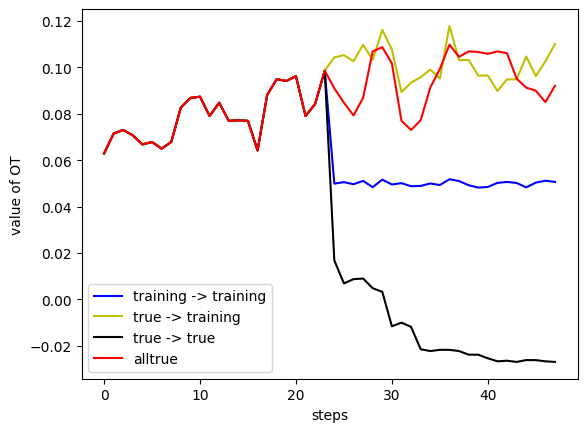

In [140]:
# 결과 1개만 뽑아냄
import matplotlib.pyplot as plt

idx = 142
var = -1
plt.plot(range(48), np.concatenate([dataset_weather_24[idx][0][:,var], preds_tr_tr[idx, :, var]]), 'b', label='training -> training') # 
plt.plot(range(48), np.concatenate([dataset_weather_24[idx][0][:,var], preds_te_tr[idx+24, :,var]]), 'y', label='true -> training') # 
plt.plot(range(48), np.concatenate([dataset_weather_24[idx][0][:,var], trues_tr_tr[idx, :, var]]),'k', label='true -> true') # 
plt.plot(range(48), np.concatenate([dataset_weather_24[idx][0][:,var], dataset_weather_24[idx+24][0][:,var]]),'r-', label='alltrue') # 
plt.xlabel('steps')
plt.ylabel('value of OT')
plt.legend()
plt.show()

In [124]:
trues_te_tr[idx, :,var], trues_tr_tr[idx-24, :, var]

(array([0.01861056, 0.01861056, 0.01756878, 0.01704789, 0.01548522,
        0.01522477, 0.01522477, 0.01522477, 0.01496432, 0.01444343,
        0.01288076, 0.01340165, 0.01235987, 0.01235987, 0.02199636,
        0.01522477, 0.01392254, 0.02121502, 0.01444343, 0.01444343,
        0.0131412 , 0.01913146, 0.00975541, 0.00923452], dtype=float32),
 array([0.0193919 , 0.01965235, 0.02017324, 0.02069413, 0.02173591,
        0.0222568 , 0.02251725, 0.02329859, 0.02460082, 0.02486126,
        0.02616349, 0.02772617, 0.0285075 , 0.0285075 , 0.0290284 ,
        0.02980973, 0.02980973, 0.03007018, 0.03111196, 0.03215374,
        0.03293508, 0.03371642, 0.03501865, 0.03632088], dtype=float32))

In [91]:
preds_tr_tr[idx, :, -1], preds_te_tr[idx+24, :, -1], trues_tr_tr[idx, :, -1]

(array([0.04080663, 0.04014615, 0.03979062, 0.03972599, 0.03934005,
        0.04124194, 0.04007404, 0.03931124, 0.03935461, 0.03896395,
        0.03988687, 0.03985279, 0.04227787, 0.04062849, 0.0398509 ,
        0.03903646, 0.03941425, 0.03979223, 0.04033612, 0.03978902,
        0.03975243, 0.04026647, 0.04035877, 0.04066249], dtype=float32),
 array([0.12835598, 0.1309903 , 0.13050307, 0.13209336, 0.12876682,
        0.13102601, 0.1315615 , 0.12701541, 0.12817392, 0.12456658,
        0.12954952, 0.12657411, 0.13726932, 0.13302703, 0.13101104,
        0.12887555, 0.12536484, 0.12599966, 0.12677805, 0.12987132,
        0.1307195 , 0.13037847, 0.13101609, 0.13116992], dtype=float32),
 array([0.02199636, 0.02199636, 0.02173591, 0.02069413, 0.01991279,
        0.01808967, 0.01678744, 0.01574566, 0.01470388, 0.01470388,
        0.01444343, 0.01418299, 0.01418299, 0.0136621 , 0.01418299,
        0.01392254, 0.01444343, 0.01470388, 0.01522477, 0.01470388,
        0.01392254, 0.01392254, 0.0134

In [137]:
dataset_weather_24[0][0] == trues_te_tr[0,:,:]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False

In [154]:
idxx = 5
MAE(trues_te_tr[idxx+24], trues_tr_tr[idxx])

1.7381275

In [ ]:
batch_x_1 = []
batch_y_1 = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):
    batch_x_1.append(batch_x)
    batch_y_1.append(batch_y)

batch_x_1 = np.concatenate(batch_x_1, axis=0)
batch_y_1 = np.concatenate(batch_y_1, axis=0)

In [ ]:
batch_x_2 = []
batch_y_2 = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):
    batch_x_2.append(batch_x)
    batch_y_2.append(batch_y)

batch_x_2 = np.concatenate(batch_x_2, axis=0)
batch_y_2 = np.concatenate(batch_y_2, axis=0)

In [ ]:
batch_y_2.shape, batch_y_1.shape

In [ ]:
np.sum(batch_y_1[:, 12:,:] == batch_y_2[:,12:,:])/batch_y_1.size, np.sum(batch_x_1[:, 12:,:] == batch_y_2[:,12:,:])/batch_y_1.size